# Pandas .transform: SQL-Like Window functions in Pandas

**1st January 2022**

Being able to slice and dice data using Pandas is a key skillset of any Data Scientist.

Data Scientists will typically work with both SQL and Pandas for transforming data, depending on the specific use case. For example, using SQL when working with a data warehouse to create new tables or views of the data and using Pandas perhaps for a more exploratory data analysis/visualisation workflow.

It is important to be fluent with both SQL and Pandas syntax to be able to seemlessly transform your data for the business question you are trying to answer.

However, there are cases where carrying out certain transformation are easier to remember in one language than the other. This can be frustrating and a productivity killer.

For me, this seems to always happen when trying to carry out transformations involving [Window Functions](https://www.sqlite.org/windowfunctions.html#:~:text=A%20window%20function%20is%20an,it%20is%20a%20window%20function.) using Pandas. I don't know what it is, but I find the SQL syntax for window functions to be much cleaner and easier to remember.

In this post, I will describe the differences between SQL and Pandas syntax for applying window functions to different partitions of your data.


## What is a Window Function?

"A window function performs a calculation across a set of table rows that are somehow related to the current row." [Postgres documentation](https://www.postgresql.org/docs/9.1/tutorial-window.html)

This is similar to a general 'aggregation' function (such as sum, mean, rolling sum etc.), however, the window function result returns a table/dataframe of the same length as the original, rather than a single row.

You can think of it as running multiple aggregations or calculations on different cross sections of the data, but then joining them back up together.

## When would you use a Window Function?

Window functions are useful for calculating quantities that rely on other values within the same group.

For example, image you have a table containing the salaries of employees in different departments. One question you might want to answer is: what is the difference between each person's salary compared to the average of *their* department. To answer the question we would need to calculate the average salary for each department and then substract this number from the salary of each employee depending on the department they belong to. A window function would be perfect for this as it can calculate aggregations against partitions in the data (in this case the different departments)...



For example, calculating the cumulative sales over the month for each product a company sells. Here, we need to calculate the running sum for each product, the value of which only relies on the sales of that product. This is a perfect usecase for window functions. 

---

# Code

## Setup

**Install requirements if necessary**

In [1]:
# install requirements if necessary
# ! pip install matplotlib pandas ffn nb_black

In [2]:
import datetime

import ffn
import matplotlib.pyplot as plt

import pandas as pd

In [3]:
%load_ext nb_black
%matplotlib inline

<IPython.core.display.Javascript object>

**Collect Data**

To demonstrate window function transformations we will use a dataset of daily stock prices of some popular companies.

We will use on of my favourite libraries for financial analysis -- the [ffn](https://pmorissette.github.io/ffn/) library -- to collect the data.

In [4]:
tickers = [
    "AAPL",  # apple
    "DIS",  # disney
    "NKE",  # nike
    "TSLA",  # tesla
]
prices = ffn.get(tickers, start="2018-01-01")

# convert data into 'long' table format for purposes of this exercise
prices = prices.melt(ignore_index=False, var_name="ticker", value_name="closing_price")

# reset index to make 'Date' a column
prices = prices.reset_index()

# example rows in the dataset
prices.sample(5).sort_index()

,Date,ticker,closing_price
1783,2021-02-02,dis,176.960007
2722,2020-10-23,nke,128.760788
3180,2018-08-20,tsla,61.688000
3698,2020-09-10,tsla,371.339996
3983,2021-10-27,tsla,1037.859985


<IPython.core.display.Javascript object>

**Save to SQLite Database**

In order to demonstrate and compare the SQL syntax to Pandas we will save this data in a simple in memory SQLite database. This allows us to use directly SQL syntax to read and transform the data.

In [5]:
import sqlite3

# create connection
with sqlite3.connect(":memory:") as conn:

    # save prices to sqlite db
    prices.to_sql(name="prices", con=conn, index=False)

<IPython.core.display.Javascript object>

> Note: SQLite does not have a 'DATE' datatype so we will have to treat the dates as strings when use SQL to demonstrate the transformations

## Window functions in SQL

Let's start by demonstrating the SQL syntax for window functions.

The [Postgres database documentation](https://www.postgresql.org/docs/9.1/tutorial-window.html) has a great tutorial on window functions.

To form a window function in SQL you need three parts:
- an aggregation function or calculation to apply to the target column (e.g. `SUM()`, `RANK()`)
- the `OVER()` keyword
- the `PARTITION BY` and/or the `ORDER BY` keyword which defines the groups of the data to apply the aggregation function

## Window Functions in Pandas

### .groupby is the basis of  window functions in Pandas

I think my confusion when trying to translate SQL window functions to Pandas stems from the fact that you don't use the `GROUP BY` keyword for window functions in SQL. Whereas, in Pandas, the basis of window functions is the [.groupby](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.groupby.html) function.

.groupby in Pandas is analagous to the function of `PARTITION BY` in SQL. The groupby clause in Pandas defines which partitions (groups) in the data the aggregation function should be applied to.

###  .transform allows you to apply complex transformations

## Examples

In [6]:
# simple window functions (sum, mean, rolling etc.)

<IPython.core.display.Javascript object>

Let's take some examples using the stock prices dataset to compare the differences between window functions in SQL and the equivalent in Pandas.

#### Rolling 28 day average for each company

**SQL**

In [7]:
seven_day_ma_sql = """
SELECT
    date(Date) as Date
    , ticker
    , closing_price
    , avg(closing_price) OVER(
        PARTITION BY ticker
        ORDER BY date(Date), ticker
        ROWS BETWEEN 27 PRECEDING AND CURRENT ROW
    )
     as ma_28_day
from prices
"""

sql_ma_result = pd.read_sql(seven_day_ma_sql, con=conn)
sql_ma_result

,Date,ticker,closing_price,ma_28_day
0,2018-01-02,aapl,41.188160,41.188160
1,2018-01-03,aapl,41.180988,41.184574
2,2018-01-04,aapl,41.372276,41.247142
3,2018-01-05,aapl,41.843311,41.396184
4,2018-01-08,aapl,41.687889,41.454525
...,...,...,...,...
4023,2021-12-23,tsla,1067.000000,1041.285716
4024,2021-12-27,tsla,1093.939941,1044.162500
4025,2021-12-28,tsla,1088.469971,1045.367499
4026,2021-12-29,tsla,1086.189941,1045.266782


<IPython.core.display.Javascript object>

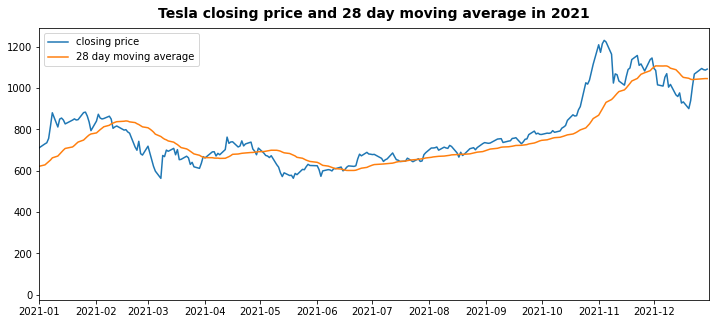

<IPython.core.display.Javascript object>

In [8]:
# plot the result for tesla to demonstrate output of window function
tsla = sql_ma_result[sql_ma_result["ticker"] == "tsla"]

plt.figure(figsize=(12, 5))
plt.plot(pd.to_datetime(tsla["Date"]), tsla["closing_price"], label="closing price")
plt.plot(pd.to_datetime(tsla["Date"]), tsla["ma_28_day"], label="28 day moving average")
plt.xlim(
    datetime.date(2021, 1, 1),
    datetime.date(2021, 12, 31),
)
plt.legend()
plt.title(
    "Tesla closing price and 28 day moving average in 2021",
    fontsize=14,
    fontweight="bold",
    pad=10,
)
plt.show()

**Pandas**

To achieve the same in Pandas we can create a new column in the dataframe ('ma_28_day') using `groupby` and `transform`. We Python's [lambda syntax](https://realpython.com/python-lambda/) to define what function should be applied to each group. In this case we want to use calculate the average (mean) over a 28 row rolling window.

In [9]:
# copy original dataframe (optional)
pd_ma_result = prices.copy()

# create new column using groupby and transform
pd_ma_result["ma_28_day"] = pd_ma_result.groupby("ticker")[["closing_price"]].transform(
    lambda group: group.rolling(28, min_periods=1).mean()
)

pd_ma_result

,Date,ticker,closing_price,ma_28_day
0,2018-01-02,aapl,41.188160,41.188160
1,2018-01-03,aapl,41.180988,41.184574
2,2018-01-04,aapl,41.372276,41.247142
3,2018-01-05,aapl,41.843311,41.396184
4,2018-01-08,aapl,41.687889,41.454525
...,...,...,...,...
4023,2021-12-23,tsla,1067.000000,1041.285716
4024,2021-12-27,tsla,1093.939941,1044.162500
4025,2021-12-28,tsla,1088.469971,1045.367499
4026,2021-12-29,tsla,1086.189941,1045.266782


<IPython.core.display.Javascript object>

In [10]:
# verify that the output of sql and pandas functions were the same
assert all(pd_ma_result.ma_28_day == sql_ma_result.ma_28_day)

<IPython.core.display.Javascript object>

**Calculate daily returns for each company**

or 

**Arbritary Function**

**SQL**

**Return the average daily stock prices for each company**

**SQL**

In [11]:
mean_price_sql = """
SELECT
    date(Date) as Date
    , ticker
    , closing_price
    , AVG(closing_price) OVER(PARTITION BY ticker) as avg_price
FROM
    prices
"""

sql_mean_result = pd.read_sql(mean_price_sql, con=conn)
sql_mean_result

,Date,ticker,closing_price,avg_price
0,2018-01-02,aapl,41.188160,82.867571
1,2018-01-03,aapl,41.180988,82.867571
2,2018-01-04,aapl,41.372276,82.867571
3,2018-01-05,aapl,41.843311,82.867571
4,2018-01-08,aapl,41.687889,82.867571
...,...,...,...,...
4023,2021-12-23,tsla,1067.000000,296.530956
4024,2021-12-27,tsla,1093.939941,296.530956
4025,2021-12-28,tsla,1088.469971,296.530956
4026,2021-12-29,tsla,1086.189941,296.530956


<IPython.core.display.Javascript object>

**Pandas**

If the function you are applying is a simple aggregation function. You can just specify the string alias e.g. 'mean' in the transform function, instead of using the lambda syntax (although the lambda syntax would still work).

In [12]:
# copy original dataframe (optional)
pd_mean_result = prices.copy()

# calculate the average stock price for each company over the period of the data
pd_mean_result["avg_price"] = pd_mean_result.groupby("ticker")[
    "closing_price"
].transform("mean")

pd_mean_result

,Date,ticker,closing_price,avg_price
0,2018-01-02,aapl,41.188160,82.867571
1,2018-01-03,aapl,41.180988,82.867571
2,2018-01-04,aapl,41.372276,82.867571
3,2018-01-05,aapl,41.843311,82.867571
4,2018-01-08,aapl,41.687889,82.867571
...,...,...,...,...
4023,2021-12-23,tsla,1067.000000,296.530956
4024,2021-12-27,tsla,1093.939941,296.530956
4025,2021-12-28,tsla,1088.469971,296.530956
4026,2021-12-29,tsla,1086.189941,296.530956


<IPython.core.display.Javascript object>

In [13]:
# verify that the output of sql and pandas functions were the same
assert all(pd_mean_result.avg_price == sql_mean_result.avg_price)

<IPython.core.display.Javascript object>

### You don't always have to use .transform

If the function you are applying to your data is not an aggregation function, i.e. it naturally returns a value (row) for every row in the dataframe, rather than a single row, you don't need to use transform keyword.

For example, if you want to create a new column with the values within each group shifted by one (i.e. the previous day's closing price) you can omit the `transform` keyword. This is because shifting the data returns a value for each row, rather than a single aggregated value for the group.

In [14]:
prices["previous_close"] = prices.groupby("ticker")["closing_price"].shift(1)

prices

,Date,ticker,closing_price,previous_close
0,2018-01-02,aapl,41.188160,NaN
1,2018-01-03,aapl,41.180988,41.188160
2,2018-01-04,aapl,41.372276,41.180988
3,2018-01-05,aapl,41.843311,41.372276
4,2018-01-08,aapl,41.687889,41.843311
...,...,...,...,...
4023,2021-12-23,tsla,1067.000000,1008.869995
4024,2021-12-27,tsla,1093.939941,1067.000000
4025,2021-12-28,tsla,1088.469971,1093.939941
4026,2021-12-29,tsla,1086.189941,1088.469971


<IPython.core.display.Javascript object>

### A Practical Example: Missing Data

In [15]:
# Real world use case. Use transform to deal with missing
# data differently for different groups
# e.g. fill group with mean for that group
# e.g. interpolation by group

<IPython.core.display.Javascript object>

## Conclusion

It is an important skill as a data scientist to be able to be flexible and able to switch between SQL and Pandas when completing data analysis.

Sometimes it is easier in one language than another to express the data transformation you want, but it is important to understand how common data transformations, such as window functions, can be achieved in either language.